# ![](https://img.shields.io/badge/vision-2f5ada)  ![](https://img.shields.io/badge/time%20series-6c4ce2)  Train Convolutional `LSTM`


In this notebook, a simple next frame video prediction using convolutional `LSTM` is demonstrated.

## Imports

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet
!pip install ml_collections --quiet

In [2]:
import serket as sk
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import ipywidgets as widgets  # interactive widgets for visualization
import optax  # gradient based optimization
from typing import Any
from ml_collections import ConfigDict  # creating simple configuration files
from typing_extensions import Annotated  # adding type annotations to arrays
from tqdm import tqdm  # progress bar

config = ConfigDict()

## Create data

In [3]:
def create_circle_frames_numpy(
    frame_size: int,
    num_frames: int,
    radius_increment: int,
    x_shift=0,
    y_shift=0,
) -> jax.Array:
    """Return frames of a circle growing in size.

    Args:
        frame_size: Size of the frame.
        num_frames: Number of frames to generate.
        radius_increment: Increment of radius between frames.
        shift: Shift of the circle's center.
    """
    center = frame_size // 2

    def draw_solid_circle_numpy(radius):
        frame = jnp.zeros((frame_size, frame_size))
        x, y = jnp.meshgrid(jnp.arange(frame_size), jnp.arange(frame_size))
        distances = (x - (center + x_shift)) ** 2 + (y - (center + y_shift)) ** 2
        frame = jnp.where(distances <= radius**2, 1, 0)
        return frame

    radii = jnp.arange(1, num_frames + 1) * radius_increment
    result = jax.vmap(draw_solid_circle_numpy)(radii)
    # add channel dimension
    return jnp.expand_dims(result, axis=1).astype(jnp.float32)

In [4]:
config.num_frames = 5
config.samples_count = 20
config.frame_size = 32

x_shifts = jr.randint(
    jr.key(0),
    (config.samples_count,),
    -(config.frame_size // 2),
    config.frame_size // 2,
)
y_shifts = jr.randint(
    jr.key(1),
    (config.samples_count,),
    -(config.frame_size // 2),
    config.frame_size // 2,
)
data = jax.vmap(
    lambda xs, ys: create_circle_frames_numpy(
        config.frame_size, config.num_frames, 1, xs, ys
    )
)(x_shifts, y_shifts)
train_data, test_data = data[: int(0.8 * len(data))], data[int(0.8 * len(data)) :]
x_train, y_train = train_data[:, :-1], train_data[:, 1:]
x_test, y_test = test_data[:, :-1], test_data[:, 1:]

## Visualize data

Plot each sample for each row and the frames on columns

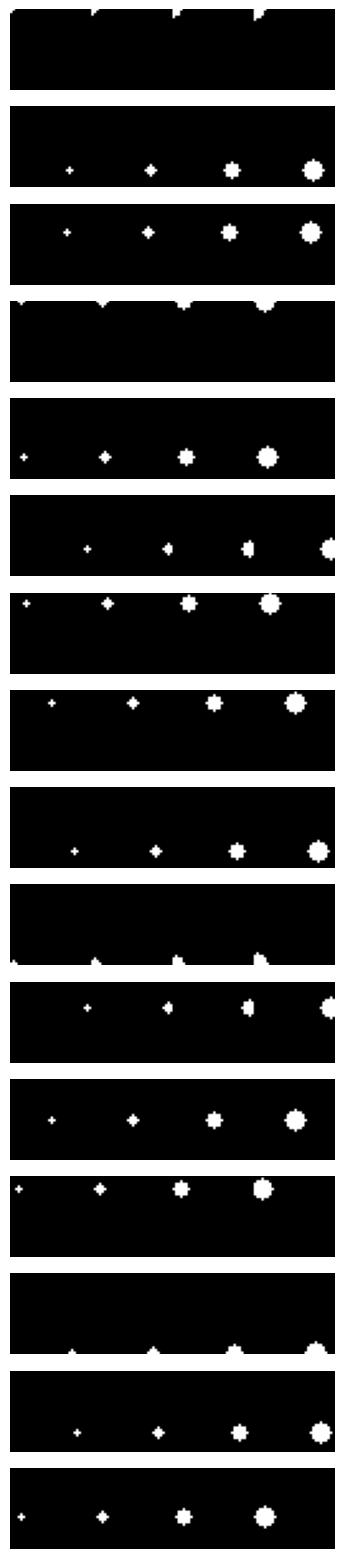

In [5]:
image = x_train[:, :, 0]
image = image.transpose(0, 2, 1, 3)
samples, frame_size, frame_count, _ = image.shape
image = image.reshape(samples, frame_size, frame_count * frame_size)
fig, axes = plt.subplots(len(image), 1, figsize=(10, 20))
for i, ax in enumerate(axes.ravel()):
    ax.axis("off")
    ax.imshow(image[i], cmap="gray")

## Model

In [6]:
class Net(sk.TreeClass):
    def __init__(self, features: int, *, key: jax.Array):
        k1, k2, k3 = jr.split(key, 3)
        self.convlstm1 = sk.nn.ConvLSTM2DCell(1, features, 5, key=k1)
        self.convlstm2 = sk.nn.ConvLSTM2DCell(features, features, 3, key=k2)
        self.conv = sk.nn.Conv2D(features, 1, 3, key=k3)

    def __call__(
        self, input: Annotated[jax.Array, "Float[F,1,H,W]"]
    ) -> Annotated[jax.Array, "Float[F,1,H,W]"]:
        # F: number of frames
        # C: number of channels
        # H: height of the frame
        # W: width of the frame
        # initialize state for the cells by passing sample input
        state = sk.tree_state(self, input=input[0])
        output, _ = sk.nn.scan_cell(self.convlstm1)(input, state.convlstm1)
        output, _ = sk.nn.scan_cell(self.convlstm2)(output, state.convlstm2)
        # vectorize convolution over frames
        output = jax.vmap(self.conv)(output)
        # apply sigmoid to get values between 0 and 1
        return jax.nn.sigmoid(output)

## Training

In [7]:
config.features = 32
config.epochs = 1000
config.key = jr.key(0)
config.optim = ConfigDict()
config.optim.kind = "adam"
config.optim.init_value = 1e-2
config.optim.boundaries = [
    int(config.epochs * 0.25),
    int(config.epochs * 0.5),
    int(config.epochs * 0.75),
]
config.optim.scales = [0.5, 0.5, 0.5]


def train(config: ConfigDict) -> Net:
    lr = optax.piecewise_constant_schedule(
        init_value=config.optim.init_value,
        boundaries_and_scales=dict(zip(config.optim.boundaries, config.optim.scales)),
    )
    optim = getattr(optax, config.optim.kind)(learning_rate=lr)
    net = sk.tree_mask(Net(features=config.features, key=config.key))
    optim_state = optim.init(net)

    print(sk.tree_summary(net, depth=1))

    def loss_func(
        net: Net,
        xb: Annotated[jax.Array, "Float[N,F,1,H,W]"],
        yb: Annotated[jax.Array, "Float[N,F,1,H,W]"],
    ):
        net = sk.tree_unmask(net)
        logits = jax.vmap(net)(xb)  # vectorize over the batch dimension
        return jnp.mean(optax.sigmoid_binary_cross_entropy(logits, yb))

    @jax.jit
    def train_step(
        net: Net,
        optim_state: Any,
        xb: Annotated[jax.Array, "Float[N,F,1,H,W]"],
        yb: Annotated[jax.Array, "Float[N,F,1,H,W]"],
    ):
        loss, grads = jax.value_and_grad(loss_func)(net, xb, yb)
        updates, optim_state = optim.update(grads, optim_state)
        net = optax.apply_updates(net, updates)
        return net, optim_state, loss

    for _ in (epoch_bar := tqdm(range(config.epochs))):
        net, optim_state, loss = train_step(net, optim_state, x_train, y_train)
        epoch_bar.set_description(f"Loss: {loss:.4e}")

    net = sk.tree_unmask(net)
    return net


net = train(config)

┌──────────┬──────────────┬───────┬────────┐
│Name      │Type          │Count  │Size    │
├──────────┼──────────────┼───────┼────────┤
│.convlstm1│ConvLSTM2DCell│105,728│413.00KB│
├──────────┼──────────────┼───────┼────────┤
│.convlstm2│ConvLSTM2DCell│73,856 │288.50KB│
├──────────┼──────────────┼───────┼────────┤
│.conv     │Conv2D        │289    │1.13KB  │
├──────────┼──────────────┼───────┼────────┤
│Σ         │Net           │179,873│702.63KB│
└──────────┴──────────────┴───────┴────────┘


Loss: 6.7987e-01: 100%|██████████| 1000/1000 [00:33<00:00, 30.02it/s]


## Visualize test predictions

(4, 32, 4, 32)


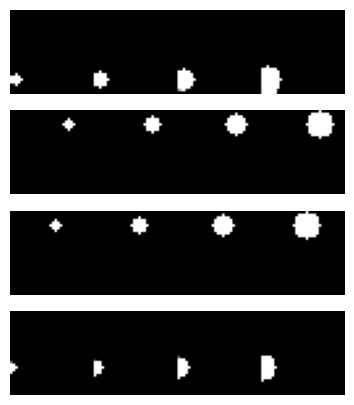

In [8]:
y_test_pred = jax.vmap(net)(x_test)
image_pred = y_test_pred[:, :, 0]
image_pred = image_pred.transpose(0, 2, 1, 3)
print(image_pred.shape)
samples, frame_size, frame_count, _ = image_pred.shape
image_pred = image_pred.reshape(samples, frame_size, frame_count * frame_size)

fig, axes = plt.subplots(len(image_pred), 1, figsize=(10, 5))

for i, ax in enumerate(axes.ravel()):
    ax.axis("off")
    ax.imshow(image_pred[i], cmap="gray")

Inspired by https://keras.io/examples/vision/conv_lstm/